In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# from surprise import Dataset, Reader, SVD
# from surprise.model_selection import cross_validate
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from keras.models import Model
from keras.layers import Input, Dense
from scipy.sparse.linalg import svds

In [19]:
# Load the dataset
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

In [20]:
# Merge datasets
df = movies.merge(credits, left_on='id', right_on='movie_id', how='inner')
df.drop(columns=['movie_id'], inplace=True)

Demographic Filtering


C:\Users\shrey\AppData\Local\Temp\ipykernel_22008\847480733.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_sorted['popularity'], y=df_sorted['title_x'], palette='Blues_r')


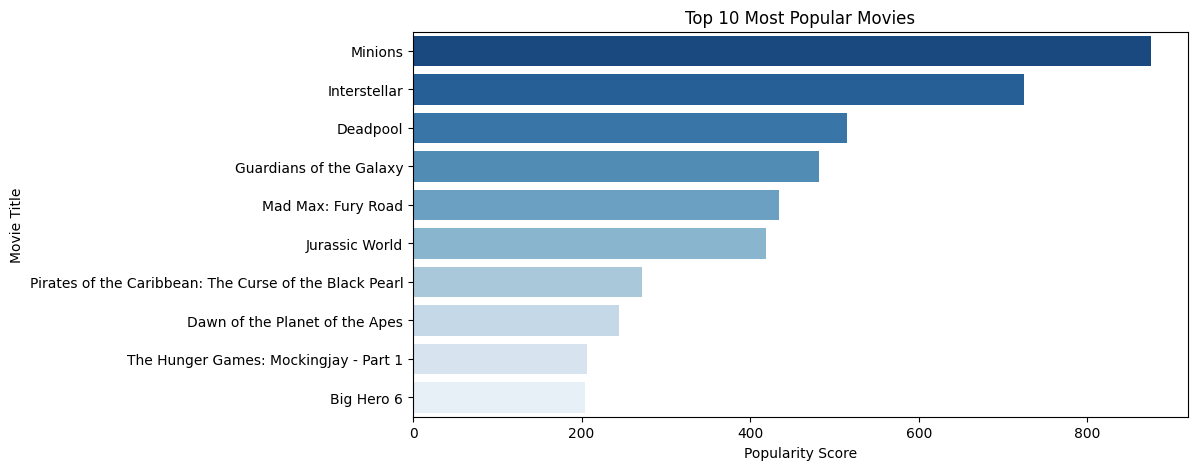

In [21]:
# Popularity-Based Model
df_sorted = df.sort_values(by='popularity', ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=df_sorted['popularity'], y=df_sorted['title_x'], palette='Blues_r')
plt.title("Top 10 Most Popular Movies")
plt.xlabel("Popularity Score")
plt.ylabel("Movie Title")
plt.show()

Content-Based Filtering

In [22]:
# Cosine Similarity
tfidf = TfidfVectorizer(stop_words='english')
df['overview'] = df['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(df['overview'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = df[df['title_x'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title_x'].iloc[movie_indices]

print("\nCosine Similarity - Based Recommendations for Avatar:\n")
print(get_recommendations("Avatar"))


Cosine Similarity - Based Recommendations for Avatar:

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title_x, dtype: object


In [23]:
# Cosine Similarity + SVD
svd = TruncatedSVD(n_components=100)
X_svd = svd.fit_transform(tfidf_matrix)

cosine_sim_svd = cosine_similarity(X_svd, X_svd)

def get_recommendations_svd(title, cosine_sim=cosine_sim_svd):
    idx = df[df['title_x'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title_x'].iloc[movie_indices]

print("\nCosine Similarity + SVD - Based Recommendations for Avatar:\n")
print(get_recommendations_svd("Avatar"))


Cosine Similarity + SVD - Based Recommendations for Avatar:

151                        Beowulf
3604                     Apollo 18
3618        Force 10 from Navarone
487                     Red Planet
972                       The Host
568                            xXx
529               Tears of the Sun
1172                   Eight Below
1106    Rambo: First Blood Part II
461                  Lost in Space
Name: title_x, dtype: object


Collaborative Filtering

In [24]:
# # Surprise SVD
# reader = Reader(rating_scale=(0.5, 5.0))
# rating_data = Dataset.load_from_df(df[['id', 'vote_average', 'vote_count']], reader)
# svd = SVD()
# cross_validate(svd, rating_data, cv=5, verbose=True)

# print("\nRecommendation System Development Completed!")

In [25]:
# KNN model
df['overview'] = df['overview'].fillna('')

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['overview'])
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(X)

def get_knn_recommendations(title, knn_model=knn, n_recommendations=10):
    idx = df[df['title_x'] == title].index[0]
    movie_vector = X[idx]
    distances, indices = knn_model.kneighbors(movie_vector, n_neighbors=n_recommendations + 1)
    recommended_indices = indices.flatten()[1:]
    return df['title_x'].iloc[recommended_indices]

print("\nKNN - Based Recommendations for Avatar:\n")
print(get_knn_recommendations("Avatar"))


KNN - Based Recommendations for Avatar:

3604                      Apollo 18
529                Tears of the Sun
151                         Beowulf
2130                   The American
1341           The Inhabited Island
634                      The Matrix
1213    Aliens vs Predator: Requiem
1610                          Hanna
1274                  Just Visiting
2616                      In Bruges
Name: title_x, dtype: object


In [26]:
# Autoencoder model
input_dim = X.shape[1]  
encoding_dim = 100  

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X.toarray(), X.toarray(), epochs=20, batch_size=256, shuffle=True)
encoder = Model(input_layer, encoded)
encoded_movies = encoder.predict(X.toarray())
cosine_sim_autoencoder = cosine_similarity(encoded_movies, encoded_movies)

def get_recommendations_autoencoder(title, cosine_sim=cosine_sim_autoencoder):
    idx = df[df['title_x'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title_x'].iloc[movie_indices]

print("\nAutoencoder - Based Recommendations for Avatar:\n")
print(get_recommendations_autoencoder("Avatar"))

Epoch 1/20
19/19 [==============================] - 4s 145ms/step - loss: 0.2431
Epoch 2/20
19/19 [==============================] - 2s 101ms/step - loss: 0.1402
Epoch 3/20
19/19 [==============================] - 2s 112ms/step - loss: 0.0253
Epoch 4/20
19/19 [==============================] - 2s 107ms/step - loss: 0.0077
Epoch 5/20
19/19 [==============================] - 2s 103ms/step - loss: 0.0048
Epoch 6/20
19/19 [==============================] - 2s 98ms/step - loss: 0.0039
Epoch 7/20
19/19 [==============================] - 2s 102ms/step - loss: 0.0033
Epoch 8/20
19/19 [==============================] - 2s 105ms/step - loss: 0.0030
Epoch 9/20
19/19 [==============================] - 2s 104ms/step - loss: 0.0027
Epoch 10/20
19/19 [==============================] - 2s 102ms/step - loss: 0.0026
Epoch 11/20
19/19 [==============================] - 2s 108ms/step - loss: 0.0024
Epoch 12/20
19/19 [==============================] - 2s 108ms/step - loss: 0.0023
Epoch 13/20
19/19 [=======

In [27]:
# SVDS model
df['user_id'] = np.random.randint(1, 1000, df.shape[0])  
df['rating'] = df['vote_average'] / 2  
ratings_pivot = df.pivot(index='user_id', columns='title_x', values='rating').fillna(0)

U, sigma, Vt = svds(ratings_pivot.values, k=50)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predictions_df = pd.DataFrame(all_user_predicted_ratings, index=ratings_pivot.index, columns=ratings_pivot.columns)

def recommend_movies(user_id, num_recommendations=5):
    user_ratings = ratings_pivot.loc[user_id]
    sorted_movies = predictions_df.loc[user_id].sort_values(ascending=False)
    recommendations = sorted_movies.index[~user_ratings.index.duplicated()].tolist()
    return recommendations[:num_recommendations]

print("\nSVDS model - Based Recommendations for User 10:")
print(recommend_movies(10))


SVDS model - Based Recommendations for User 10:
['Love Jones', 'The Big Parade', 'Nowhere in Africa', 'Fateless', 'The Mighty Ducks']
